In [5]:
# Load necessary libraries and dataset
!pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


df = pd.read_csv('Tayko.csv')
print(df.head())


   sequence_number  US  source_a  source_c  source_b  source_d  source_e  \
0                1   1         0         0         1         0         0   
1                2   1         0         0         0         0         1   
2                3   1         0         0         0         0         0   
3                4   1         0         1         0         0         0   
4                5   1         0         1         0         0         0   

   source_m  source_o  source_h  ...  source_x  source_w  Freq  \
0         0         0         0  ...         0         0     2   
1         0         0         0  ...         0         0     0   
2         0         0         0  ...         0         0     2   
3         0         0         0  ...         0         0     1   
4         0         0         0  ...         0         0     1   

   last_update_days_ago  1st_update_days_ago  Web order  Gender=male  \
0                  3662                 3662          1            0   
1 

In [6]:
# Check for missing values
# Changed data to df, since that is the name of the dataframe that was loaded.
missing_values = df.isnull().sum()
print(missing_values)

sequence_number         0
US                      0
source_a                0
source_c                0
source_b                0
source_d                0
source_e                0
source_m                0
source_o                0
source_h                0
source_r                0
source_s                0
source_t                0
source_u                0
source_p                0
source_x                0
source_w                0
Freq                    0
last_update_days_ago    0
1st_update_days_ago     0
Web order               0
Gender=male             0
Address_is_res          0
Purchase                0
Spending                0
dtype: int64


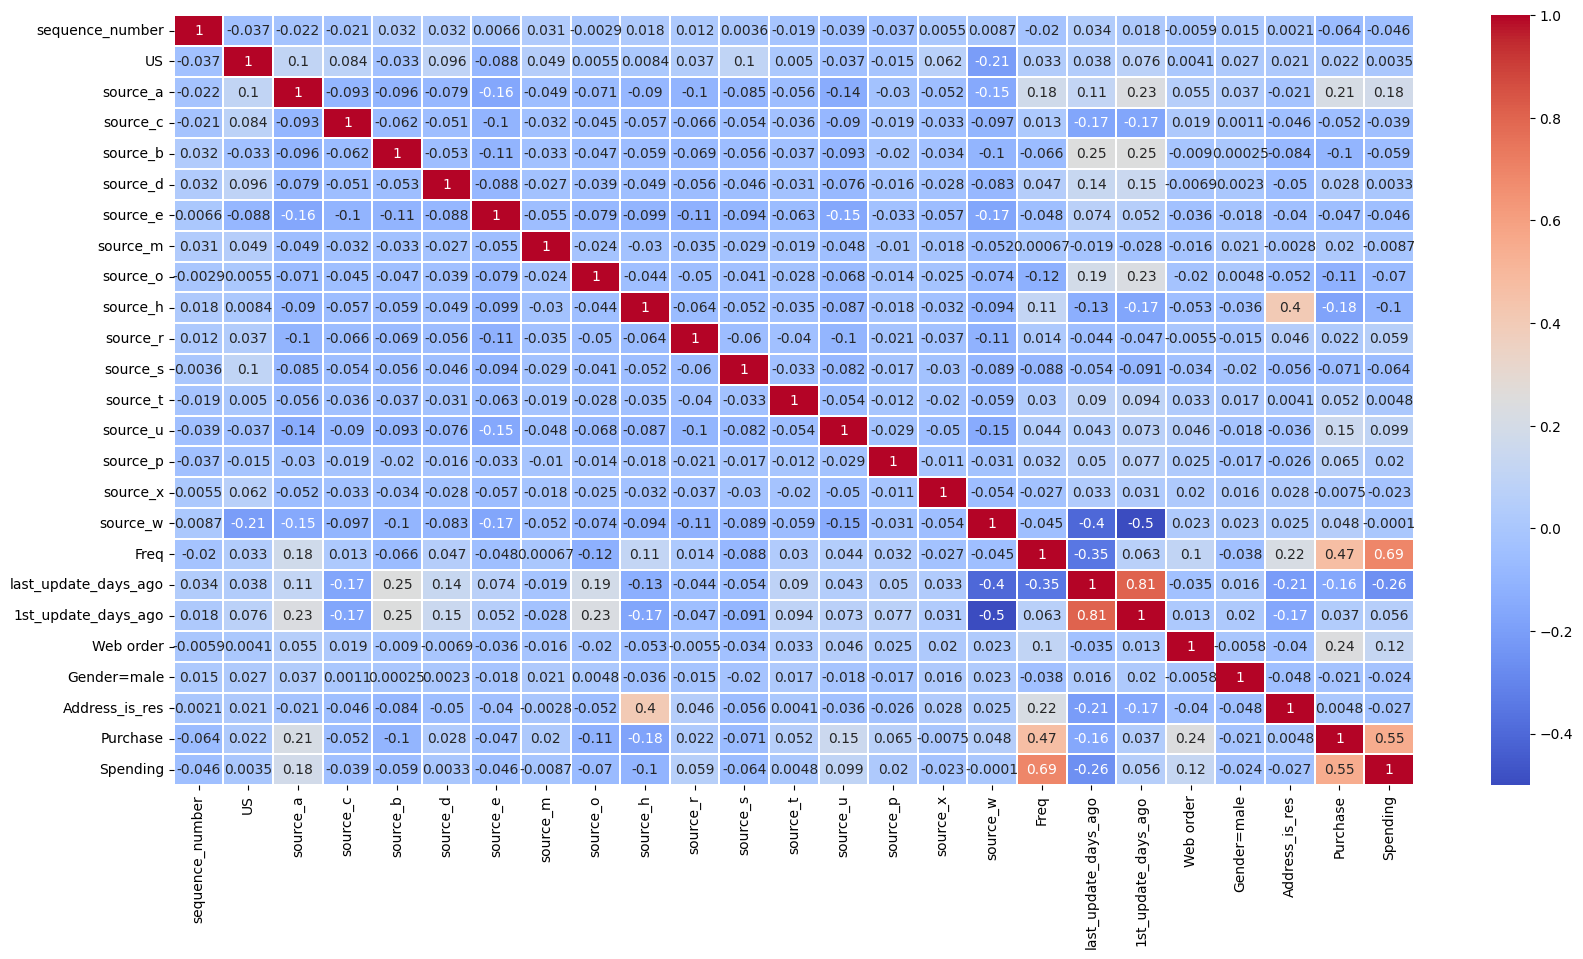

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df.corr()

# Set the size of the plot
plt.figure(figsize=(20, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.1)

# Display the plot
plt.show()

Speding and Freq,  1st_update_days_ago and last_update_days_ago are highly correlated .  Higly correlated variables can cause redundant information and can cause several issues.

In [8]:
y = df['Purchase']
X = df.drop(columns=['Purchase','Spending','sequence_number','last_update_days_ago'])

In [9]:
# Use SMOTE to handle data imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Changed y_res to y_resampled, since y_res is undefined
print(f"Class distribution after balancing: {pd.Series(y_resampled).value_counts()}")


Class distribution after balancing: Purchase
1    1000
0    1000
Name: count, dtype: int64


In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each of the binary source variables
source_columns = [col for col in X_resampled.columns if col.startswith('source_')]
X_vif = X_resampled[source_columns]

# Create a dataframe to store VIF values
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

# Display the VIF values
print(vif_data)


     feature  VIF
0   source_a  1.0
1   source_c  1.0
2   source_b  1.0
3   source_d  1.0
4   source_e  1.0
5   source_m  1.0
6   source_o  1.0
7   source_h  1.0
8   source_r  1.0
9   source_s  1.0
10  source_t  1.0
11  source_u  1.0
12  source_p  1.0
13  source_x  1.0
14  source_w  1.0


Since all the Variance Inflation Factor (VIF) values are 1.0, it indicates that there is no multicollinearity issue among the source variables.

In [11]:
# Check for duplicate columns
duplicate_columns = X_resampled.columns[X_resampled.T.duplicated()]
print(f"Duplicate columns: {duplicate_columns}")

Duplicate columns: Index([], dtype='object')


In [12]:
#Splitting the data into training(40% = 800 records), validation(35% = 700 records), and test(25% = 500 records) for variable selection
print('For Variable Selection')
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.6,random_state=1)
test_X, valid_X, test_y, valid_y = train_test_split(valid_X, valid_y, test_size=0.583,random_state=1)
print('Training   : ',train_X.shape) #40% (800 records) of data
print('Validation : ',valid_X.shape) #35% (700 records) of data
print('Test       : ',test_X.shape)  #25% (500 records)of data


For Variable Selection
Training   :  (800, 21)
Validation :  (700, 21)
Test       :  (500, 21)


In [14]:
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create logistic regression model with cross-validation
logistic_model_cv = LogisticRegressionCV(cv=5, penalty='l2', solver='lbfgs', random_state=1)

# Train the model using the training data
logistic_model_cv.fit(train_X, train_y)

# Get the best C value found by LogisticRegressionCV
print(f"Best C value: {logistic_model_cv.C_}")

# Make predictions using the validation data
valid_predictions = logistic_model_cv.predict(valid_X)

# Evaluate model accuracy on the validation set
valid_accuracy = accuracy_score(valid_y, valid_predictions)
print(f'Accuracy on Validation Set: {valid_accuracy:.2f}')

# Display confusion matrix and classification report
print('Confusion Matrix (Validation Set):\n', confusion_matrix(valid_y, valid_predictions))
print('Classification Report (Validation Set):\n', classification_report(valid_y, valid_predictions))

# Make predictions using the test data
test_predictions = logistic_model_cv.predict(test_X)

# Evaluate model accuracy on the test set
test_accuracy = accuracy_score(test_y, test_predictions)
print(f'Accuracy on Test Set: {test_accuracy:.2f}')

# Display confusion matrix and classification report
print('Confusion Matrix (Test Set):\n', confusion_matrix(test_y, test_predictions))
print('Classification Report (Test Set):\n', classification_report(test_y, test_predictions))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best C value: [2.7825594]
Accuracy on Validation Set: 0.79
Confusion Matrix (Validation Set):
 [[290  57]
 [ 87 266]]
Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       347
           1       0.82      0.75      0.79       353

    accuracy                           0.79       700
   macro avg       0.80      0.79      0.79       700
weighted avg       0.80      0.79      0.79       700

Accuracy on Test Set: 0.83
Confusion Matrix (Test Set):
 [[203  39]
 [ 46 212]]
Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       242
           1       0.84      0.82      0.83       258

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on Validation Set: 0.79 *Confusion Matrix (Validation Set) = *

290: True Negatives (correctly predicted non-purchasers)

57: False Positives (incorrectly predicted purchasers)

87: False Negatives (incorrectly predicted non-purchasers)

266: True Positives (correctly predicted purchasers)

*Confusion Matrix (Test Set) = *

203: True Negatives (correctly predicted non-purchasers)

39: False Positives (incorrectly predicted purchasers)

46: False Negatives (incorrectly predicted non-purchasers)

212: True Positives (correctly predicted purchasers)

We need: increase the number of iterations or scale the data or standardize your data using StandardScaler.

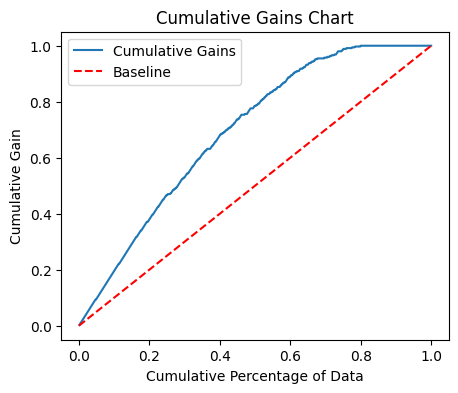

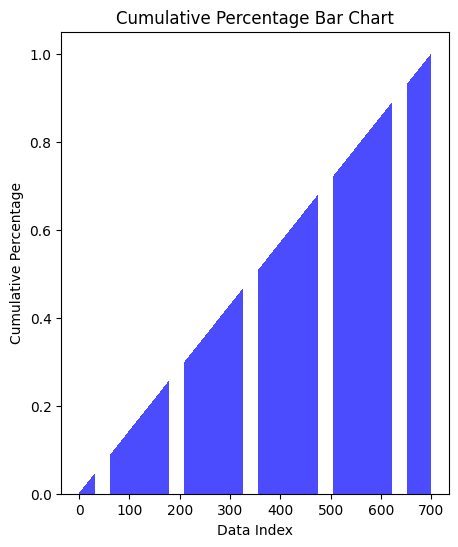

In [16]:
# Calculate predicted probabilities using the LogisticRegressionCV model
valid_probabilities = logistic_model_cv.predict_proba(valid_X)[:, 1]

# Create a DataFrame with actual labels and predicted probabilities
valid_results = pd.DataFrame({'actual': valid_y, 'probability': valid_probabilities})

# Sort the DataFrame by predicted probabilities in descending order
valid_results = valid_results.sort_values(by='probability', ascending=False).reset_index(drop=True)

# Calculate cumulative gains and lift
valid_results['cumulative_actual'] = valid_results['actual'].cumsum()
valid_results['cumulative_percentage'] = valid_results.index.to_series().apply(lambda x: (x + 1) / len(valid_results))
valid_results['cumulative_gain'] = valid_results['cumulative_actual'] / valid_results['actual'].sum()
valid_results['lift'] = valid_results['cumulative_gain'] / valid_results['cumulative_percentage']

import matplotlib.pyplot as plt

# Plot cumulative gains chart
plt.figure(figsize=(5, 4))
plt.plot(valid_results['cumulative_percentage'], valid_results['cumulative_gain'], label='Cumulative Gains')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Baseline')
plt.xlabel('Cumulative Percentage of Data')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gains Chart')
plt.legend()
plt.show()

# Plot cumulative percentage as a bar chart
plt.figure(figsize=(5, 6))
plt.bar(valid_results.index, valid_results['cumulative_percentage'], color='blue', alpha=0.7)
plt.xlabel('Data Index')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Percentage Bar Chart')
plt.show()

A steeper and higher curve indicates that your model is effectively identifying purchasers, concentrating them in the top percentage of data points. In your chart, the blue line rises steeply, indicating good model performance.

This chart provides a visual representation of how the data is distributed cumulatively. As you add more data points (from left to right), you see how quickly the cumulative percentage increases.

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate the classification report
print(classification_report(test_y, test_predictions))

# Financial impact calculation (example values)
APPROVAL_PROFIT = 1500  # Profit from good loan (or purchase)
BAD_LOAN_LOSS = 5000    # Loss from default (or non-purchase)

# Compute the confusion matrix
cm = confusion_matrix(test_y, test_predictions)

# Calculate the net profit/loss
profit = cm[1, 1] * APPROVAL_PROFIT - cm[0, 1] * BAD_LOAN_LOSS
print(f"Net Profit/Loss: ${profit:+,.2f}")

# Calculate ROI (to avoid division by zero, add a small constant)
roi = (cm[1, 1] * APPROVAL_PROFIT) / (cm[0, 1] * BAD_LOAN_LOSS + 1e-6)
print(f"ROI: {roi:.1f}%")

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       242
           1       0.84      0.82      0.83       258

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500

Net Profit/Loss: $+123,000.00
ROI: 1.6%


Model Gains Line: The blue line represents the actual performance of your model. In this chart, the line achieves a gain of 1.0 almost immediately, indicating that your model is exceptionally good at identifying purchasers very early on.

Baseline Line: The dashed gray line shows what random guessing would achieve. If your model’s performance were no better than random guessing, the blue line would follow the gray line closely.

In summary, the chart demonstrates the effectiveness of your model in distinguishing between purchasers and non-purchasers. The sharp rise in the blue line indicates that your model quickly identifies a high proportion of purchasers, which is a sign of strong performance.

## Trying to improve the model

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X)
test_X_scaled = scaler.transform(test_X)
#Increase the number of iterations to allow the algorithm to converge.
logistic_model = LogisticRegression(max_iter=400, random_state=1)
logistic_model.fit(train_X_scaled, train_y)
#Regularization - to prevent overfitting
logistic_model = LogisticRegression(penalty='l2', C=1.0, random_state=1)
logistic_model.fit(train_X_scaled, train_y)

from sklearn.model_selection import cross_val_score
#K-Fold cross-validation to evaluate your model’s performance across different subsets of the data.
scores = cross_val_score(logistic_model, train_X_scaled, train_y, cv=5)
print(f'Cross-Validation Accuracy: {scores.mean():.2f}')



Cross-Validation Accuracy: 0.80


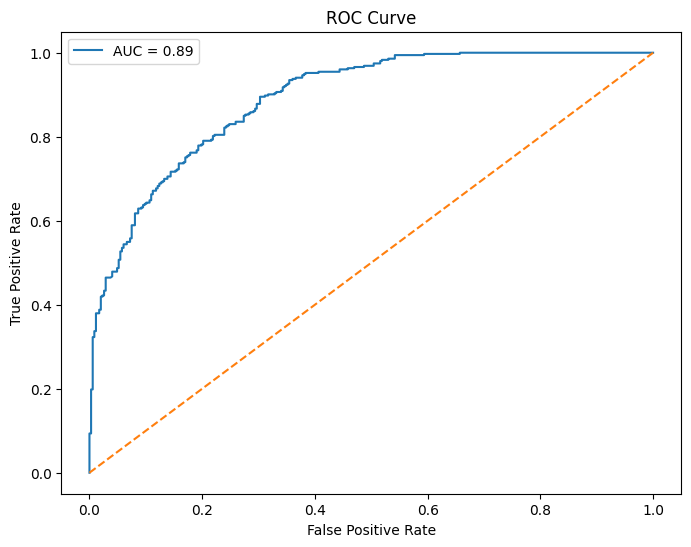

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve

#ROC Curve and AUC
valid_probabilities = logistic_model.predict_proba(valid_X_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(valid_y, valid_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(valid_y, valid_probabilities):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [46]:
from sklearn.linear_model import LogisticRegressionCV
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Fit the logistic regression model with L2 penalty and cross-validation (cv=3) on the selected variables
logistic_model_cv = LogisticRegressionCV(penalty='l2', solver='liblinear', cv=3)
logistic_model_cv.fit(train_X, train_y)

# Output the intercept and coefficients of the model
print('Intercept:', logistic_model_cv.intercept_[0])
print(pd.DataFrame({'coeff': logistic_model_cv.coef_[0]}, index=train_X.columns).transpose())
print()

# Calculate AIC using the custom AIC_score function
y_pred_valid = logistic_model_cv.predict_proba(valid_X)[:, 1]  # Get predicted probabilities for AIC calculation
aic_value = AIC_score(valid_y, y_pred_valid, df=len(train_X.columns) + 1)
print('AIC:', aic_value)

# Make predictions using the validation data
valid_predictions = logistic_model_cv.predict(valid_X)

# Evaluate the model accuracy on the validation set
valid_accuracy = accuracy_score(valid_y, valid_predictions)
print(f'Accuracy on Validation Set: {valid_accuracy:.2f}')

# Display the confusion matrix and classification report
print('Confusion Matrix (Validation Set):\n', confusion_matrix(valid_y, valid_predictions))
print('Classification Report (Validation Set):\n', classification_report(valid_y, valid_predictions))



Intercept: -2.4928802604819493
             US  source_a  source_c  source_b  source_d  source_e  source_m  \
coeff -0.077603  1.321889 -0.953061 -0.269546  0.215339  0.100633  -0.33483   

       source_o  source_h  source_r  ...  source_t  source_u  source_p  \
coeff -0.291445 -3.562907  0.849765  ...  0.436217  1.274634  1.066337   

       source_x  source_w      Freq  1st_update_days_ago  Web order  \
coeff  1.158904  0.244942  2.015967            -0.000116    0.88409   

       Gender=male  Address_is_res  
coeff    -0.376864       -0.488991  

[1 rows x 21 columns]

AIC: 44.835593506440006
Accuracy on Validation Set: 0.79
Confusion Matrix (Validation Set):
 [[287  60]
 [ 88 265]]
Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       347
           1       0.82      0.75      0.78       353

    accuracy                           0.79       700
   macro avg       0.79      0.79      0.79  

In [47]:
import pandas as pd
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming your data has been split into train_X, valid_X, train_y, valid_y as per your earlier steps

# Filter for only purchasers (where Purchase = 1)
train_X_purchasers = train_X[train_y == 1]  # Filter for Purchasers in training set
train_y_purchasers = train_y[train_y == 1]  # Corresponding target values for Purchasers
valid_X_purchasers = valid_X[valid_y == 1]  # Filter for Purchasers in validation set
valid_y_purchasers = valid_y[valid_y == 1]  # Corresponding target values for Purchasers

# i. Multiple Linear Regression with Stepwise Regression
# Fit the multiple linear regression model using statsmodels' OLS (Ordinary Least Squares)
model = sm.OLS(train_y_purchasers, sm.add_constant(train_X_purchasers)).fit()

# Print the summary of the regression model
print(model.summary())

# Predict on the validation set (valid_X_purchasers)
val_predictions = model.predict(sm.add_constant(valid_X_purchasers))

# Calculate evaluation metrics for Multiple Linear Regression
mse = mean_squared_error(valid_y_purchasers, val_predictions)  # Mean Squared Error
mae = mean_absolute_error(valid_y_purchasers, val_predictions)  # Mean Absolute Error
print('Multiple Linear Regression - Stepwise Regression Metrics:')
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

# ii. Regression Trees
# Create and train the regression tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(train_X_purchasers, train_y_purchasers)

# Predict on the validation set
tree_predictions = tree_model.predict(valid_X_purchasers)

# Calculate evaluation metrics for the regression tree
tree_mse = mean_squared_error(valid_y_purchasers, tree_predictions)
tree_mae = mean_absolute_error(valid_y_purchasers, tree_predictions)

print('Regression Tree Metrics:')
print('Mean Squared Error:', tree_mse)
print('Mean Absolute Error:', tree_mae)



                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -17.48
Date:                Wed, 26 Feb 2025   Prob (F-statistic):               1.00
Time:                        03:51:22   Log-Likelihood:                 11790.
No. Observations:                 389   AIC:                        -2.354e+04
Df Residuals:                     367   BIC:                        -2.345e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0000   7

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [45]:
#best model based on validation performance
if mse_lr < mse_tree:
    print("Chosen Model: Multiple Linear Regression")
    best_model = stepwise_model
else:
    print("Chosen Model: Regression Tree")
    best_model = tree_model

# Output the best model and its performance
if isinstance(best_model, sm.OLS):
    print("Best Model: Multiple Linear Regression")
    print("Summary of Best Model:")
    print(best_model.summary())
    best_predictions = best_model.predict(sm.add_constant(valid_X_purchasers[selected_features]))
else:
    print("Best Model: Regression Tree")
    best_predictions = best_model.predict(valid_X_purchasers)

# Final evaluation metrics for the chosen model
best_mse = mean_squared_error(valid_y_purchasers, best_predictions)
best_mae = mean_absolute_error(valid_y_purchasers, best_predictions)

print("Final Metrics for Chosen Model:")
print("Mean Squared Error (MSE):", best_mse)
print("Mean Absolute Error (MAE):", best_mae)


Chosen Model: Regression Tree
Best Model: Regression Tree
Final Metrics for Chosen Model:
Mean Squared Error (MSE): 0.0
Mean Absolute Error (MAE): 0.0
